<a href="https://colab.research.google.com/github/omarDrame/Tabular-classification/blob/main/Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import

In [1]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import xgboost as xgb 
import lightgbm as lgbm
import optuna
from optuna.samplers import TPESampler
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
warnings.simplefilter('ignore')

from sklearn.linear_model import LinearRegression

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, make_scorer

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The data set

- Flight = the origin-destination pair (LAX-ORD, ATL-LAX, etc.)
- Carrier = the carrier operating the flight (American Airlines, Delta Air Lines, etc.)
- Month = the month of the flight (June, July, or August)
- DayOfWeek = the day of the week of the flight (Monday, Tuesday, etc.)
- NumPrevFlights = the number of previous flights taken by this aircraft in the same day
- PrevFlightGap = the amount of time between when this flight’s aircraft is scheduled to arrive at the airport and when it’s scheduled to depart for this flight
- HistoricallyLate = the proportion of time this flight has been late historically
- InsufficientHistory = whether or not we have enough data to determine the historical record of the flight (equal to 1 if we don’t have at least 3 records, equal to 0 if we do)
- OriginInVolume = the amount of incoming traffic volume at the origin airport, normalized by the typical volume during the flight’s time and day of the week
- OriginOutVolume = the amount of outgoing traffic volume at the origin airport, normalized by the typical volume during the flight’s time and day of the week
- DestInVolume = the amount of incoming traffic volume at the destination airport, normalized by the typical volume during the flight’s time and day of the week
- DestOutVolume = the amount of outgoing traffic volume at the destination airport, normalized by the typical volume during the flight’s time and day of the week
- OriginPrecip = the amount of rain at the origin over the course of the day, in tenths of millimeters
- OriginAvgWind = average daily wind speed at the origin, in miles per hour
- OriginWindGust = fastest wind speed during the day at the origin, in miles per hour
- OriginFog = whether or not there was fog at some point during the day at the origin (1 if there was, 0 if there wasn’t)
- OriginThunder = whether or not there was thunder at some point during the day at the origin (1 if there was, 0 if there wasn’t)
- DestPrecip = the amount of rain at the destination over the course of the day, in tenths of millimeters
- DestAvgWind = average daily wind speed at the destination, in miles per hour
- DestWindGust = fastest wind speed during the day at the destination, in miles per hour
- DestFog = whether or not there was fog at some point during the day at the destination (1 if there was, 0 if there wasn’t)
- DestThunder = whether or not there was thunder at some point during the day at the destination (1 if there was, 0 if there wasn’t)
- TotalDelay = the amount of time the aircraft was delayed, in minutes (this is our dependent variable)

# Data Loading

We ‘re going to split the data from the very beginning, we want our test set to not leak into the training phase. There are no missing values in the dataset, so we don’t have to worry about that. We want to make assumptions on the training set and verify if these assumptions are confirmed in the testing set, if this is the case we can hope that our analysis could be generalized to broader data.

In [6]:
path = '/content/drive/My Drive/DataScience/Classification/Airline/'
data = pd.read_csv(path +'AirlineDelay.csv')
target = data.columns[-1]
features = [feature for feature in data.columns if feature not in target]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size = 0.2, random_state = 0)

We seperate the categorical features from the numerical ones.

In [8]:
features_cat = ['Flight','Carrier','Month','DayOfWeek']

features_num = [
 'NumPrevFlights',
 'PrevFlightGap',
 'HistoricallyLate',
 'InsufficientHistory',
 'OriginInVolume',
 'OriginOutVolume',
 'DestInVolume',
 'DestOutVolume',
 'OriginPrecip',
 'OriginAvgWind',
 'OriginWindGust',
 'OriginFog',
 'OriginThunder',
 'DestPrecip',
 'DestAvgWind',
 'DestWindGust',
 'DestFog',
 'DestThunder']

# EDA

In [9]:
data.shape

(9381, 23)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9381 entries, 0 to 9380
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Flight               9381 non-null   object 
 1   Carrier              9381 non-null   object 
 2   Month                9381 non-null   object 
 3   DayOfWeek            9381 non-null   object 
 4   NumPrevFlights       9381 non-null   int64  
 5   PrevFlightGap        9381 non-null   int64  
 6   HistoricallyLate     9381 non-null   float64
 7   InsufficientHistory  9381 non-null   int64  
 8   OriginInVolume       9381 non-null   float64
 9   OriginOutVolume      9381 non-null   float64
 10  DestInVolume         9381 non-null   float64
 11  DestOutVolume        9381 non-null   float64
 12  OriginPrecip         9381 non-null   int64  
 13  OriginAvgWind        9381 non-null   float64
 14  OriginWindGust       9381 non-null   float64
 15  OriginFog            9381 non-null   i

In [11]:
data.head(-5)

,Flight,Carrier,Month,DayOfWeek,NumPrevFlights,PrevFlightGap,HistoricallyLate,InsufficientHistory,OriginInVolume,OriginOutVolume,...,OriginAvgWind,OriginWindGust,OriginFog,OriginThunder,DestPrecip,DestAvgWind,DestWindGust,DestFog,DestThunder,TotalDelay
0,LAX-ORD,American Airlines,June,Wednesday,1,55,0.000000,1,1.053360,1.026930,...,9.618842,19.908766,0,0,132,7.381902,16.105968,0,0,25
1,LAX-ORD,American Airlines,June,Thursday,1,55,0.000000,1,1.021611,1.019608,...,8.724066,18.119214,0,0,0,10.066230,23.935258,0,0,0
2,LAX-ORD,American Airlines,June,Friday,2,35,0.000000,1,1.029703,0.998214,...,7.605596,16.105968,1,0,0,9.842536,18.119214,0,0,0
3,LAX-ORD,American Airlines,June,Sunday,1,30,0.250000,0,1.087935,1.001789,...,7.605596,17.000744,0,0,0,15.658580,31.988242,0,0,0
4,LAX-ORD,American Airlines,June,Monday,1,55,0.200000,0,1.044177,0.994662,...,8.947760,18.119214,0,0,0,8.724066,17.000744,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9371,ATL-LAX,Southwest Airlines,July,Saturday,0,240,0.200000,0,0.984193,0.992577,...,5.144962,14.987498,0,0,0,7.605596,14.987498,0,0,0
9372,ATL-LAX,Southwest Airlines,July,Saturday,1,240,0.166667,0,0.973378,0.992577,...,7.605596,16.105968,1,0,0,6.934514,14.987498,0,0,4
9373,ATL-LAX,Southwest Airlines,July,Saturday,1,240,0.142857,0,0.973378,0.992577,...,5.816044,14.987498,0,0,0,7.605596,16.105968,0,0,0
9374,ATL-LAX,Southwest Airlines,August,Saturday,1,240,0.125000,0,0.984193,0.978791,...,7.158208,14.092722,0,0,3,7.158208,16.105968,0,0,0


## Target distribution

In [12]:
nb_observations = len(data[target])
observation_with_delay = data[target].loc[data[target] >0].count()
print(f'Out of {nb_observations} observations {observation_with_delay} are with delay \n i.e {observation_with_delay/nb_observations:.2%}')

Out of 9381 observations 4693 are with delay 
 i.e 50.03%


We can take a look at the delay per observation in the training set.

Text(0.5, 0, 'Observation')

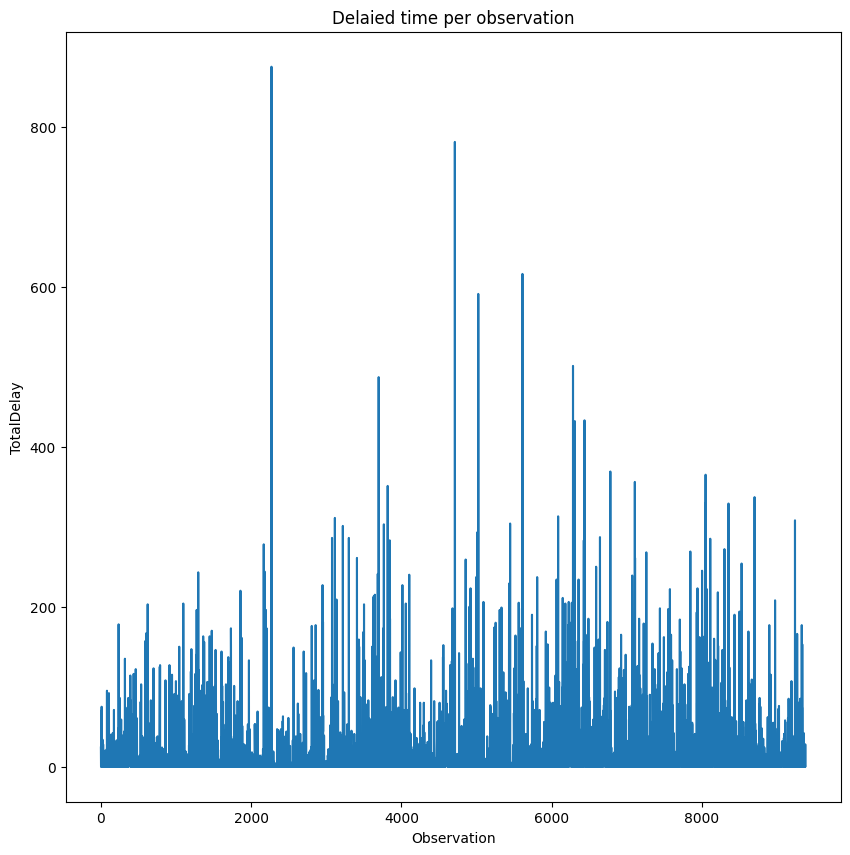

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.set_theme(style="darkgrid")
sns.lineplot(x=y_train.index,y=y_train,)
ax.set_title("Delaied time per observation")
ax.set_xlabel("Observation")

## Feature distributions

We can look at all the features’ distributions.

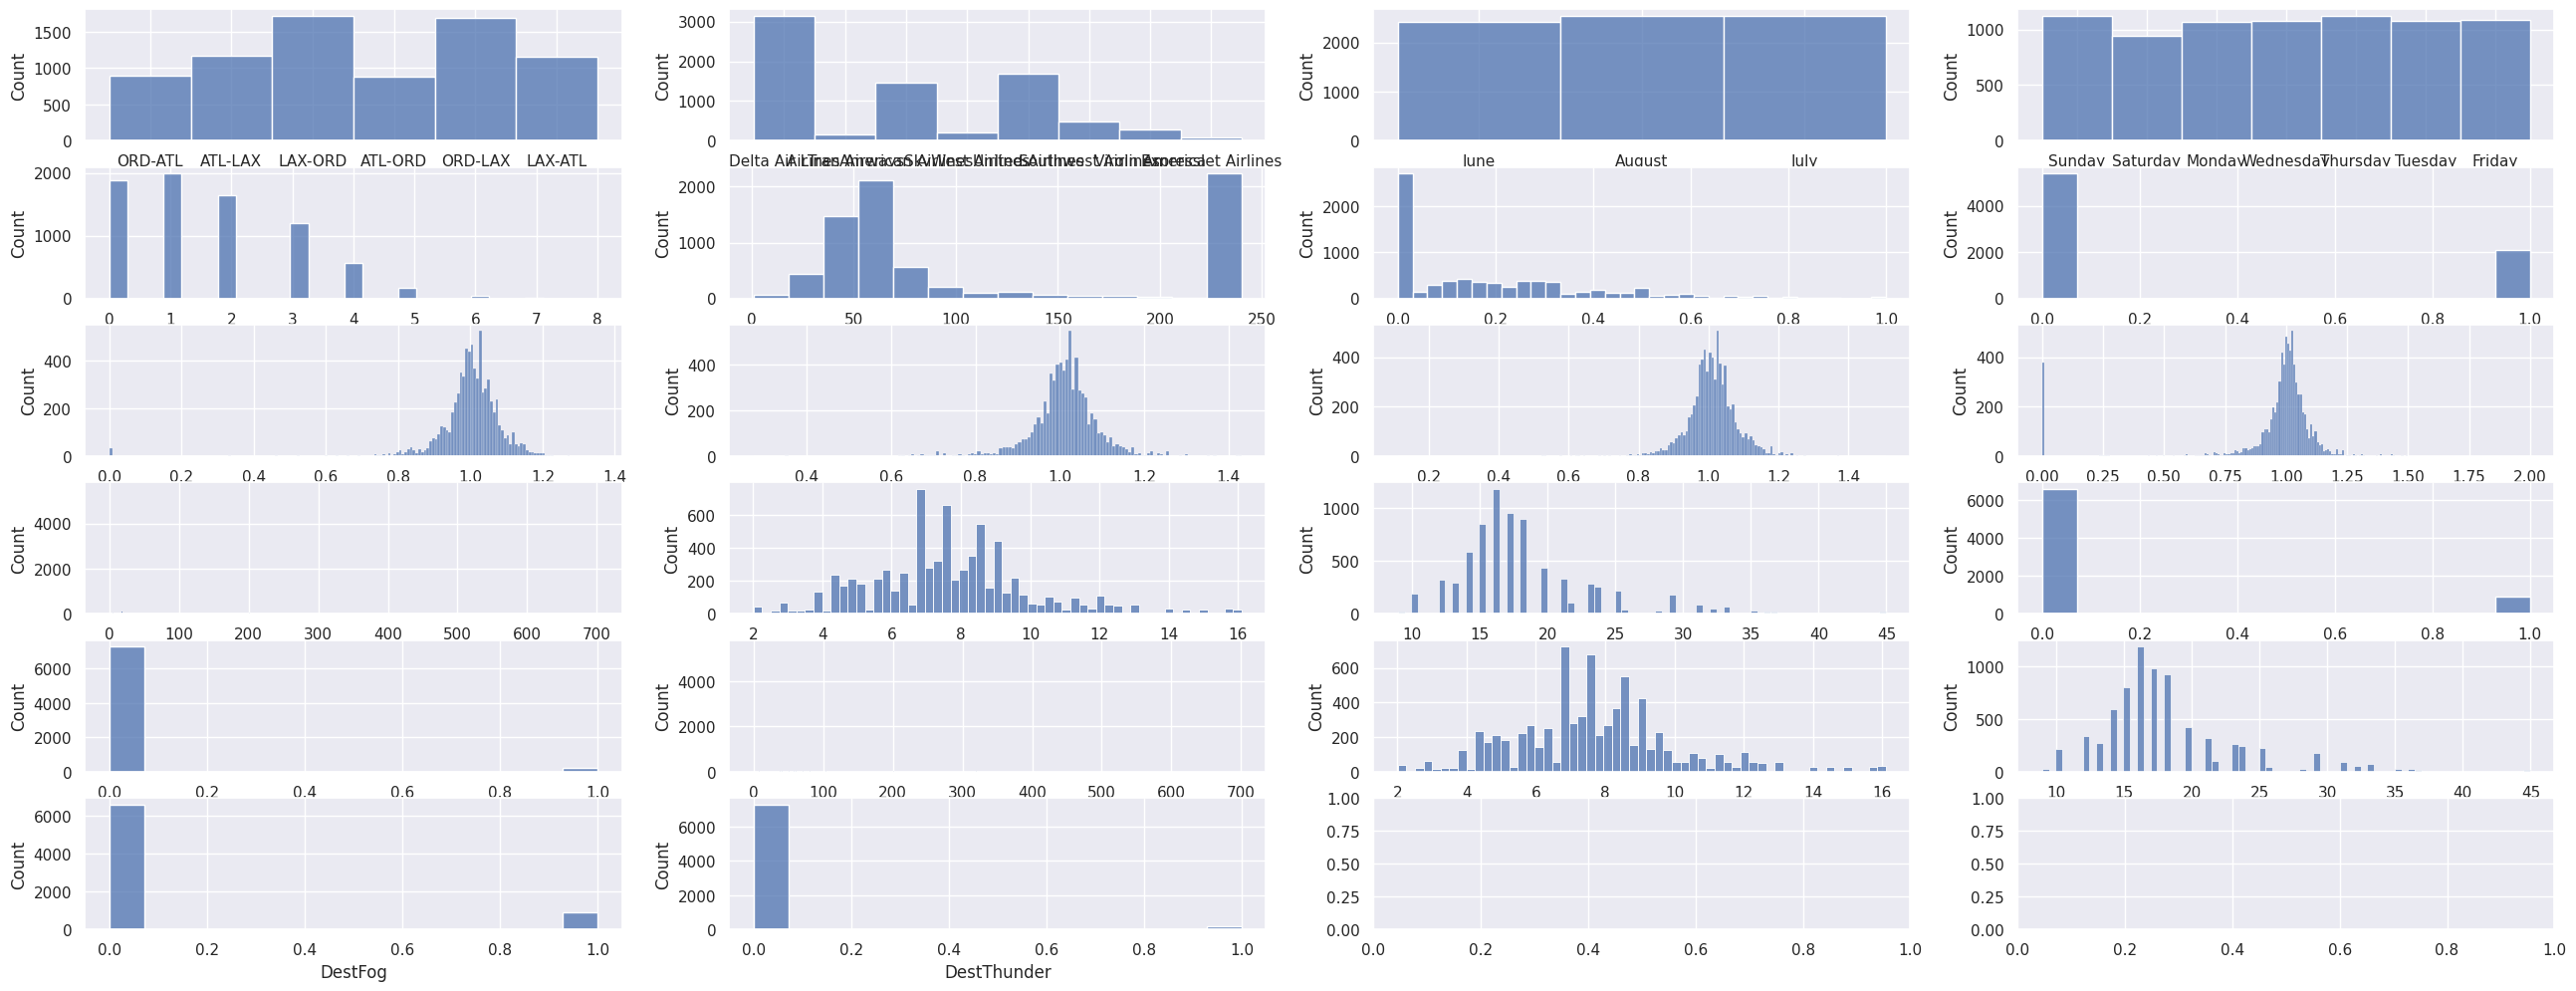

In [14]:
fig, axs = plt.subplots(6,4, figsize=(32,12))

for f, ax in zip(features,axs.ravel()):
    sns.histplot(X_train, x=f, ax=ax)
plt.show()

## Linear Correlations


Overall, the variables are not very correlated to each other. The target has a correlation close to 0 to every other variable which could indicate that ether a flight is going to be late of not doesn’t depend on only one factor but on a combination of factors.

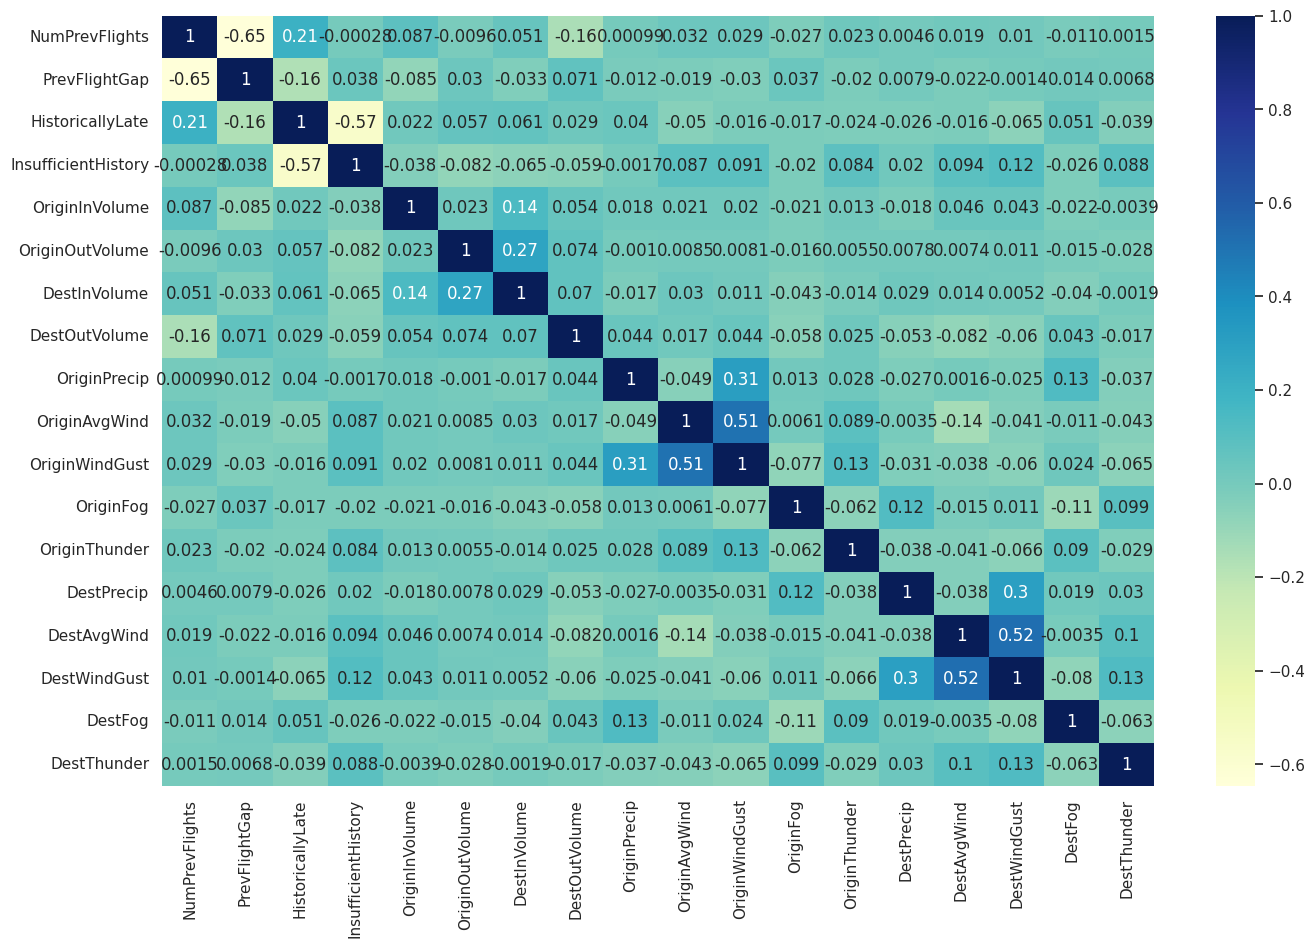

In [15]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
matrix = X_train.corr()
sns.heatmap(matrix, annot=True,cmap="YlGnBu")
plt.show()

## Target and features

# Preprocessing

## Missing values

In [16]:
# data.isna().sum() NONE

## Outliers

Some values are really extreme here, we have clear outliers. We're going to use  the 3 sigma rules to remove the observations with outliers.

In [17]:
summary = X_train.describe()
print(summary)

       NumPrevFlights  PrevFlightGap  HistoricallyLate  InsufficientHistory  \
count     7504.000000    7504.000000       7504.000000          7504.000000   
mean         1.640192     114.983076          0.189704             0.280251   
std          1.391915      85.416132          0.208318             0.449151   
min          0.000000       1.000000          0.000000             0.000000   
25%          0.000000      51.000000          0.000000             0.000000   
50%          1.000000      61.000000          0.137931             0.000000   
75%          3.000000     240.000000          0.302326             1.000000   
max          8.000000     240.000000          1.000000             1.000000   

       OriginInVolume  OriginOutVolume  DestInVolume  DestOutVolume  \
count     7504.000000      7504.000000   7504.000000    7504.000000   
mean         0.998207         1.011346      1.007253       0.951875   
std          0.105116         0.084436      0.083587       0.242405   
min 

In [18]:
from scipy.stats import zscore

def three_sigma_rule(X=X_train, features_num=features_num, y=y_train):
  """
  Use the '2.5' sigma rule to delete rows with outliers values
  """
  train_normalized = X[features_num].apply(zscore)
  outlier_mask = train_normalized[(~(train_normalized<2.5).all(axis=1))].index
  train_normalized = train_normalized.drop(outlier_mask)
  print(f"{len(outlier_mask)} values deleted")
  X = X.drop(outlier_mask).reset_index(drop=True)
  y = y.drop(outlier_mask).reset_index(drop=True)
  return X, y

## Scaling Encoding

We scale our numerical values and use one hot encoder, using one hot encoder for the categorical ones. Here using ohe won’t be a problem because there are not a lot of possible values for our categorical variable.

## Feature selection

In [19]:
# Coied from a Kaggle notebook I cannot find
import eli5
from eli5.sklearn import PermutationImportance

def perm_imp(model,X_train,target):
    X = X_train.to_numpy().copy()
    y = target.to_numpy().copy()
    print(f"There are {X_train.shape[1]} possible variables")
    permute = PermutationImportance(model,random_state=2023,n_iter =2,cv=10,scoring='neg_root_mean_squared_error').fit(X_train, target)
    eli5.show_weights(permute, feature_names = X_train.columns.tolist(),top=50)
    values = dict(zip(list(X_train.columns),list(permute.feature_importances_)))
    sorted_dict = {}
    sorted_keys = sorted(values, key=values.get)
    for w in sorted_keys:
        sorted_dict[w] = np.round(values[w],3)
    print(sorted_dict)
    return sorted_dict

def remove_features(model, X_train, y_train,features=features, features_num=features_num,features_cat=features_cat):
  dictionary_importance = perm_imp(model, X_train, y_train)
  i= 0
  X_train_copy = X_train.copy()
  for feature in X_train_copy[features] :
    if dictionary_importance[feature] <= 0.0 :
      X_train_copy.drop(feature,axis=1,inplace=True)
      i = i + 1
      features.remove(feature)
      print(f'The feature {feature} is removed')
      try :
        features_num.remove(feature)
      except:
        try :
          features_cat.remove(feature)
        except :
          pass
  print(f'{i} features removed')
  return X_train_copy,features


In [20]:
def scale_encode(X_train=X_train,X_test=X_test,features_num=features_num,features_cat=features_cat):
  transformer_num = make_pipeline(
      #SimpleImputer(strategy="mean"),
      StandardScaler(),
  )


  transformer_cat = make_pipeline(
      #SimpleImputer(strategy="most_frequent", fill_value="NA"),
      OneHotEncoder(),
  )



  transformer_cat = make_pipeline(
      #SimpleImputer(strategy="most_frequent", fill_value="NA"),
      OneHotEncoder(handle_unknown='ignore'),
  )


  preprocessor = make_column_transformer(
      (transformer_num, features_num),
      (transformer_cat, features_cat)
      
  )

  X_train = preprocessor.fit_transform(X_train)
  X_test = preprocessor.transform(X_test)

  ohe_feature_names = preprocessor.named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names_out(features_cat)
  features_ohe = list(features_num) + list(ohe_feature_names)

  #X_train = X_train.toarray()
  #X_test = X_test.toarray()
  X_train = pd.DataFrame(X_train, columns=features_ohe)
  X_test = pd.DataFrame(X_test, columns=features_ohe)
  return X_train, X_test, features_ohe

## Preprocess

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size = 0.2, random_state = 0)
X_train, y_train = three_sigma_rule()
regressor = LinearRegression()
X_train, X_test, features_ohe = scale_encode(X_train=X_train,X_test=X_test,features_num=features_num,features_cat=features_cat)
X_train,features = remove_features(regressor, X_train, y_train, features = features_ohe)



3152 values deleted
There are 42 possible variables
{'OriginInVolume': -0.019, 'NumPrevFlights': -0.01, 'DestAvgWind': -0.001, 'OriginFog': 0.0, 'OriginThunder': 0.0, 'DestFog': 0.0, 'DestThunder': 0.0, 'DestOutVolume': 0.001, 'OriginOutVolume': 0.006, 'DestInVolume': 0.009, 'PrevFlightGap': 0.021, 'DestPrecip': 0.08, 'OriginAvgWind': 0.086, 'DestWindGust': 0.105, 'OriginPrecip': 0.133, 'OriginWindGust': 0.227, 'InsufficientHistory': 0.657, 'HistoricallyLate': 1.774, 'Carrier_ExpressJet Airlines': 483538347391.07, 'Carrier_SkyWest Airlines': 595662845930.482, 'Carrier_AirTran Airways': 656778635625.23, 'Carrier_Virgin America': 1000023861274.527, 'Carrier_Southwest Airlines': 1082614856470.276, 'Carrier_American Airlines': 1919342020517.87, 'Carrier_United Airlines': 1989302966521.579, 'DayOfWeek_Friday': 2276901628841.926, 'Carrier_Delta Air Lines': 2316326867167.878, 'DayOfWeek_Monday': 2354871460015.98, 'DayOfWeek_Tuesday': 2380616799598.264, 'DayOfWeek_Wednesday': 2673577852857.929

In [22]:
from sklearn.metrics import r2_score
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

def get_rmse(y_test,y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  return rmse


def forward_ms(X, y) :
    lin_reg = LinearRegression()
    n_folds = 5
    kf = KFold(n_splits=n_folds)
    best_columns = []
    nb_max = 20
    print(f"Forward regression with {X.shape[1]} possible variables ")
    for i in range(1, X.shape[1]):
      if i < nb_max :
        for cols in combinations(range(X.shape[1]), i):
            cols = np.array(cols)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index, cols], X.iloc[test_index, cols]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                lin_reg.fit(X_train, y_train)
                y_pred = lin_reg.predict(X_test)
                rmse = get_rmse(y_test, y_pred)
                if len(best_columns) == 0 or rmse < best_rmse:
                    best_columns = cols
                    best_rmse = rmse
                    R2 = r2_score(y_test, y_pred)
        print(best_columns, "with  RMSE %.2f" %rmse, "R2 %.2f" %R2)
        print()
      else :
          pass
    return best_columns, best_rmse, R2

# forward_ms(X_train, y_train)

def apply_foraward_selection(X_train, X_test):
  best_columns = []
  X_train = X_train.iloc[:, best_columns]
  X_test = X_test.iloc[:, best_columns]
  return X_train, X_test

# apply_foraward_selection(X_train, X_test)

## Real classification target

The classification will be as follow:
- **0** = *No delay*
- **1** = *A delay of less than 30 minutes*
- **2** = *A delay of more than 30 minutes*


In [23]:
def trueClasses(y):
  for i in range(len(y)) :
    if y.iloc[i] == 0:
      y.iloc[i] = 0

    elif y.iloc[i] >= 30:
      y.iloc[i] = 2

    else :
      y.iloc[i] = 1
  return y
  
y_train = trueClasses(y_train)
y_test = trueClasses(y_test)

# Modeling

In [24]:
# X_train.reset_index(drop=True)
y_train.to_frame()
#y_train.reset_index(drop=True)
y_test.to_frame()
# y_test.reset_index(drop=True)

,TotalDelay
5745,0
2229,0
5888,0
3460,1
888,2
...,...
6863,2
8502,0
6360,1
3209,0


## Balance

*Add weight*

In [25]:
"""vc = y_test.value_counts()
plt.bar(["No delay", "Minor delay", 'Major delay'], vc)
plt.suptitle('Delays', size=18)
plt.show()"""

'vc = y_test.value_counts()\nplt.bar(["No delay", "Minor delay", \'Major delay\'], vc)\nplt.suptitle(\'Delays\', size=18)\nplt.show()'

The data set is not balanced so using accuracy as a quality metric could be misleading. We can use kappa (or other metrics) to take into account the fact of being right by chance. For this notebook we’re going to use Kappa-Cohen. In the CV we're going to use StratifiedKFold to keep the same proportion in the target.

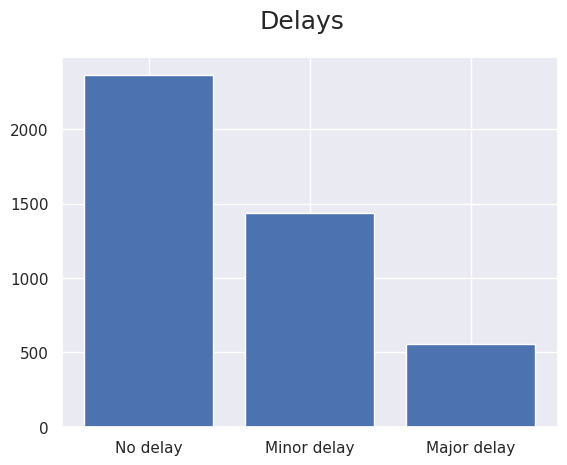

In [26]:
vc2 = y_train.value_counts()
plt.bar(["No delay", "Minor delay", 'Major delay'], vc2)
plt.suptitle('Delays', size=18)
plt.show()

# Classification

In [27]:
scorer = make_scorer(cohen_kappa_score)

# Benchmark model

We create a naive model that follow the majority class for all the prediction to evaluate the models.

In [28]:
naive_solution = y_test.copy() 
naive_solution = naive_solution.apply(lambda x:0)
kappa = cohen_kappa_score(naive_solution,y_test)
accuracy = accuracy_score(naive_solution,y_test)
print(f'The majority class on testing has a kappa of {kappa} and an accuracy of {accuracy}')

The majority class on testing has a kappa of 0.0 and an accuracy of 0.4906766116142781


*Note that for the sake of time I didn't do an exhaustive hyperparameter optimization.*

## Models

In [29]:
MODELS = ['QDA','LDA', 'NB', 'LR', 'SVM', 'DT', 'KNN', 'RF']
GB_MODELS = ['LGB', 'XGB', 'CB']
ALL_MODELS = ['QDA','LDA', 'NB', 'LR', 'SVM', 'DT', 'KNN', 'RF','LGB', 'XGB', 'CB']
TRIALS_PER_MODEL = [1000, 1000, 1000, 200, 10, 200, 100, 100, 100, 100, 100]
# TRIALS_PER_MODEL = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [30]:
# Store the objective function for HP optimization
objectives = {}
# Store the best HP
studies_best_param = {}

## HP Optimization

In [31]:
def objectiveQDA(trial):    
    reg_param = trial.suggest_float('reg_param', 0.0, 1.0)
    tol = trial.suggest_float('tol', 1e-6, 1e-2)
     
    n = trial.suggest_int('n_cv', 3, 10)
    qda = QuadraticDiscriminantAnalysis(reg_param=reg_param, tol=tol)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(qda, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['QDA'] = objectiveQDA
    

In [32]:

def objectiveLDA(trial):    
    params_optuna = {
    'solver' : trial.suggest_categorical('solver', ['lsqr', 'eigen']),
    'shrinkage' : trial.suggest_float('shrinkage', 0, 1)}
    n = trial.suggest_int('n_cv', 3, 10)
    scorer = make_scorer(cohen_kappa_score)
    lda = LinearDiscriminantAnalysis(**params_optuna)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(lda, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['LDA'] = objectiveLDA


In [33]:


def objectiveNB(trial):    
    params_optuna = {'var_smoothing' : trial.suggest_loguniform('var_smoothing', 1e-12, 1e-3)}
    NB = GaussianNB(**params_optuna)

    n = trial.suggest_int('n_cv', 3, 10)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(NB, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['NB'] = objectiveNB


In [34]:


def objectiveLR(trial):    
    params_optuna = {'C' : trial.suggest_float('C', 1e-6, 1e6, log=True),
    'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2']),
    'solver' : trial.suggest_categorical('solver', ['liblinear', 'saga']),
    'max_iter' : trial.suggest_int('max_iter', 100, 10000),
    }
    n = trial.suggest_int('n_cv', 3, 10)
    scorer = make_scorer(cohen_kappa_score)
    lr = LogisticRegression(**params_optuna)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(lr, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['LR'] = objectiveLR

In [35]:

def objectiveSVM(trial):    
    params_optuna = {'C' : trial.suggest_float('C', 1e-6, 1e6, log=True),
    'kernel' : trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
    'gamma' : trial.suggest_float('gamma', 1e-6, 1e6, log=True),
    'degree' : trial.suggest_int('degree', 2, 5),
    }
    n = trial.suggest_int('n_cv', 3, 10)
    scorer = make_scorer(cohen_kappa_score)
    svm = SVC(**params_optuna)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['SVM'] = objectiveSVM

In [36]:
def objectiveDT(trial):    
    params_optuna = {'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'max_depth' : trial.suggest_int('max_depth', 1, 20),
    #'min_samples_split' : trial.suggest_int('min_samples_split', 2, 1000),
    #'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 1000),
    'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    n = trial.suggest_int('n_cv', 3, 10)
    scorer = make_scorer(cohen_kappa_score)
    dt = DecisionTreeClassifier(**params_optuna)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['DT'] = objectiveDT

In [37]:
def objectiveKNN(trial):    
    params_optuna = { 'n_neighbors' : trial.suggest_int('n_neighbors', 1, 99),
    'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'p' : trial.suggest_int('p', 1, 5)
    }
    n = trial.suggest_int('n_cv', 3, 10)
    scorer = make_scorer(cohen_kappa_score)
    knn = KNeighborsClassifier(**params_optuna)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(knn, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['KNN'] = objectiveKNN

In [38]:
def objectiveRF(trial):    
    params_optuna = {     'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
    'max_depth' : trial.suggest_int('max_depth', 2, 20),
    # 'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
    # 'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
    # 'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    # 'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    n = trial.suggest_int('n_cv', 3, 10)
    scorer = make_scorer(cohen_kappa_score)
    rf = RandomForestClassifier(**params_optuna)
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=skf,scoring=scorer)
    return scores.mean()

objectives['RF'] = objectiveRF

In [39]:

def objectiveLGB(trial):    
    params_optuna = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_classes': 3,
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        #'min_child_samples': trial.suggest_int('min_child_samples', 5, 1000),
        #'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        #'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 10000),
        'num_class': 3
    }
    fold_scores = []
    n = trial.suggest_int('n_cv', 3, 10)
    skf = StratifiedKFold(n, shuffle=True, random_state=42)
    for (train_index,val_index) in skf.split(X_train,y_train):
      X_train_cv = X_train.iloc[train_index, :]
      y_train_cv = y_train.iloc[train_index]
      X_val = X_train.iloc[val_index, :]
      y_val = y_train.iloc[val_index]
      lgbm = lgb.LGBMClassifier(**params_optuna)
      lgbm.fit(X_train_cv,
                  y_train_cv,
                  eval_set= [(X_val,y_val)],
                  early_stopping_rounds = 50,
                  verbose=500)
      pred_val = lgbm.predict(X_val)
      score = cohen_kappa_score(y_val,pred_val)
      fold_scores.append(score)
    return np.mean(fold_scores)

objectives['LGB'] = objectiveLGB

In [40]:
import xgboost as xgb

def objectiveXGB(trial):    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.3),
        # 'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        # 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_class': 3
    }
    n = trial.suggest_int('n_cv', 3, 10)
    fold_scores = []
    skf = StratifiedKFold(n, shuffle=True, random_state=42)
    for (train_index,val_index) in skf.split(X_train,y_train):
      X_train_cv = X_train.iloc[train_index, :]
      y_train_cv = y_train.iloc[train_index]
      X_val = X_train.iloc[val_index, :]
      y_val = y_train.iloc[val_index]
      model = xgb.XGBClassifier(**params)
      model.fit(X_train_cv,
                  y_train_cv,
                  eval_set= [(X_val,y_val)],
                  early_stopping_rounds = 50,
                  verbose=0)
      pred_val = model.predict(X_val)
      score = cohen_kappa_score(y_val,pred_val)
      fold_scores.append(score)
    return np.mean(fold_scores)

objectives['XGB'] = objectiveXGB

In [41]:
from catboost import CatBoostClassifier
def objectiveCB(trial):    

    param = { 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.3),
              'iterations': trial.suggest_int('iterations', 100, 1000),
              #'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 100),
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 16),
        # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass',
        "used_ram_limit": "3gb",
    }

    """if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)
    """
    fold_scores = []
    n = trial.suggest_int('n_cv', 3, 10)
    skf = StratifiedKFold(n, shuffle=True, random_state=42)
    for (train_index,val_index) in skf.split(X_train,y_train):
      X_train_cv = X_train.iloc[train_index, :]
      y_train_cv = y_train.iloc[train_index]
      X_val = X_train.iloc[val_index, :]
      y_val = y_train.iloc[val_index]
      model = CatBoostClassifier(**param)
      model.fit(X_train_cv,
                  y_train_cv,
                  eval_set= [(X_val,y_val)],
                  early_stopping_rounds = 50,
                  verbose=0)
      pred_val = model.predict(X_val)
      score = cohen_kappa_score(y_val,pred_val)
      fold_scores.append(score)
    return np.mean(fold_scores)

objectives['CB'] = objectiveCB

In [42]:
def hyperparam_optimization(model, n_trials=1000,objectives=objectives,studies_best_param=studies_best_param ):
  study = optuna.create_study(direction='maximize', sampler = TPESampler())
  objective = objectives[model]
  study.optimize(objective, n_trials)
  print(f"The best param for {model} are {study.best_params}")
  studies_best_param[model] = study.best_params
  return studies_best_param

In [43]:
ALL_MODELS = ['QDA','LDA', 'NB', 'LR', 'DT', 'KNN', 'RF','LGB', 'XGB', 'CB'] # except SVM
TRIALS_PER_MODEL = [1000, 1000, 1000, 200, 200, 100, 100, 100, 100, 100]

In [44]:
def full_study(ALL_MODELS=ALL_MODELS,TRIALS_PER_MODEL=TRIALS_PER_MODEL):
  for model,n_trials in zip(ALL_MODELS,TRIALS_PER_MODEL):
    studies_best_param = hyperparam_optimization(model,n_trials)
  return studies_best_param

In [45]:
def get_manual_HPO_results() :
    # The best param for QDA are {'reg_param': 0.04388824200462745, 'tol': 0.0035045721341471995, 'n_cv': 5}
    # The best param for QDA are {'reg_param': 0.05332467874393636, 'tol': 0.0014443178836190578, 'n_cv': 9}
    studies_best_param['QDA'] = {'reg_param': 0.04388824200462745, 'tol': 0.0035045721341471995, 'n_cv': 5}
    
    # The best param for LDA are {'solver': 'lsqr', 'shrinkage': 0.07328578103604234, 'n_cv': 7}
    # The best param for LDA are {'solver': 'eigen', 'shrinkage': 0.673181514234649, 'n_cv': 9}
    studies_best_param['LDA'] = {'solver': 'lsqr', 'shrinkage': 0.07328578103604234, 'n_cv': 7}

    # The best param for NB are {'var_smoothing': 1.9526286310714126e-05, 'n_cv': 10}
    # The best param for NB are {'var_smoothing': 1.366826137788951e-08, 'n_cv': 10}
    studies_best_param['NB'] = {'var_smoothing': 1.9526286310714126e-05, 'n_cv': 10}

    # The best param for LR are {'C': 15.801030197378028, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 113, 'n_cv': 7}
    # The best param for LR are {'C': 132.23842421426693, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 3027, 'n_cv': 5}
    studies_best_param['LR'] = {'C': 15.801030197378028, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 113, 'n_cv': 7}

    studies_best_param['SVM'] = {'n_cv': 5}

    # The best param for DT are {'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'n_cv': 10}
    # The best param for DT are {'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'n_cv': 6}
    studies_best_param['DT'] = {'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'n_cv': 10}

    # The best param for KNN are {'n_neighbors': 8, 'weights': 'distance', 'p': 1, 'n_cv': 8}
    # The best param for KNN are {'n_neighbors': 7, 'weights': 'distance', 'p': 1, 'n_cv': 5}
    studies_best_param['KNN'] = {'n_neighbors': 8, 'weights': 'distance', 'p': 1, 'n_cv': 8}

    # The best param for RF are {'n_estimators': 919, 'max_depth': 19, 'n_cv': 6}
    # The best param for RF are {'n_estimators': 433, 'max_depth': 12, 'n_cv': 6}
    studies_best_param['RF'] = {'n_estimators': 919, 'max_depth': 19, 'n_cv': 6}

    # The best param for LGB are {'learning_rate': 0.12172763518928582, 'num_leaves': 310, 'max_depth': 3, 'n_estimators': 2788, 'n_cv': 10}
    # The best param for LGB are {'learning_rate': 0.07620875829719675, 'num_leaves': 697, 'max_depth': 4, 'n_estimators': 5785, 'n_cv': 6}
    studies_best_param['LGB'] = {'learning_rate': 0.12172763518928582, 'num_leaves': 310, 'max_depth': 3, 'n_estimators': 2788, 'n_cv': 10}

    # The best param for XGB are {'n_estimators': 655, 'max_depth': 8, 'learning_rate': 0.21395226067171733, 'n_cv': 5}
    # The best param for XGB are {'n_estimators': 483, 'max_depth': 11, 'learning_rate': 0.07513538577897937, 'n_cv': 4}
    studies_best_param['XGB'] =  {'n_estimators': 655, 'max_depth': 8, 'learning_rate': 0.21395226067171733, 'n_cv': 5}
    
    # The best param for CB are {'learning_rate': 0.02210938179404541, 'iterations': 820, 'depth': 9, 'n_cv': 8}. 
    studies_best_param['CB'] = {'learning_rate': 0.02210938179404541, 'verbose':False, 'iterations': 820, 'depth': 9, 'n_cv': 8}

    # studies_best_param
    return studies_best_param


In [46]:
studies_best_param = get_manual_HPO_results()
# studies_best_param = full_study()

In [47]:
def get_nb_cv(my_dict) :
  last_key = list(my_dict.keys())[-1]
  last_value = my_dict[last_key]
  nb_cv = last_value
  return nb_cv

def get_real_HP(my_dict):
  items_except_nbcv = list(my_dict.items())[:-1]
  result_dict = {key: value for key, value in items_except_nbcv}
  return result_dict


## CV on training

In [48]:
def get_model(model,studies_best_param=studies_best_param):
  # Store the models
    models = {}

    models['QDA'] = QuadraticDiscriminantAnalysis(**get_real_HP(studies_best_param['QDA']))
    models['LDA'] = LinearDiscriminantAnalysis(**get_real_HP(studies_best_param['LDA']))
    models['NB'] = GaussianNB(**get_real_HP(studies_best_param['NB']))
    models['LR'] = LogisticRegression(**get_real_HP(studies_best_param['LR']))
    models['SVM'] = SVC()
    models['DT'] = DecisionTreeClassifier(**get_real_HP(studies_best_param['DT']))
    models['KNN'] = KNeighborsClassifier(**get_real_HP(studies_best_param['KNN']))
    models['RF'] = RandomForestClassifier(**get_real_HP(studies_best_param['RF']))
    models['LGB'] = lgb.LGBMClassifier(**get_real_HP(studies_best_param['LGB']))
    models['XGB'] = xgb.XGBClassifier(**get_real_HP(studies_best_param['XGB']))
    models['CB'] = CatBoostClassifier(**get_real_HP(studies_best_param['CB']))
    for model_string in models :
      if model == model_string:
        return models[model]
      else :
        return models

In [49]:
def cv_on_training_classic(model,model_object,n_splits,algo_type,studies_best_param):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = []
    oof_true = []
    print(f'Model : {model}, n_splits = {n_splits}')

    for (train_index,val_index) in skf.split(X_train,y_train):
        X_train_cv = X_train.iloc[train_index, :]
        y_train_cv = y_train.iloc[train_index]
        X_val = X_train.iloc[val_index, :]
        y_val = y_train.iloc[val_index]
        params = studies_best_param[model]
        if model in ["CB"]:
           model_object.fit(X_train_cv,
              y_train_cv,
              eval_set= [(X_val,y_val)],
              early_stopping_rounds = 200,
              verbose=False)
        elif algo_type == 'bossting':
          model_object.fit(X_train_cv,
              y_train_cv,
              eval_set= [(X_val,y_val)],
              early_stopping_rounds = 200,
              verbose=0)
        else :
          model_object.fit(X_train_cv,
                y_train_cv)

        pred_val = model_object.predict(X_val)
        score = cohen_kappa_score(y_val,pred_val)

        #out of fold
        oof_preds.extend(pred_val)
        oof_true.extend(y_val)
        # print('=== Fold Score %.4f' %score, '===')
    print("OOF Results")
    print('Kappa score %.4f '%cohen_kappa_score(oof_preds,oof_true))
    print('Accuracy %.4f '%accuracy_score(oof_preds,oof_true))
    print('========================================')
    print()

In [50]:
def cv_on_training(model,studies_best_param=studies_best_param):
  if model in ['XGB', 'LGB', 'CB'] :
    algo_type = 'boosting'
  else :
    algo_type = 'classic'
  studies_best_param_copy = studies_best_param.copy()

  params = studies_best_param_copy[model]
  n_splits = get_nb_cv(params)
  model_object = get_model(model,studies_best_param_copy)
  cv_on_training_classic(model=model,model_object=model_object, n_splits=n_splits,algo_type=algo_type, studies_best_param=studies_best_param_copy)


In [51]:
"""
for model in ALL_MODELS + ['SVM'] :
  cv_on_training(model)
  print()
  
"""

"\nfor model in ALL_MODELS + ['SVM'] :\n  cv_on_training(model)\n  print()\n  \n"

The best models are the following :

In [ ]:
"""SELECTED_MODELS = [ 'RF', 'QDA','LGB',]
for model in SELECTED_MODELS :
  cv_on_training(model)
  print()"""

In [53]:
models = get_model(0,studies_best_param)

## Ensemble learning

Ensemble 1 : Let's keep the best model for this catboost, xgboost, lgboost and qda.

In [ ]:
# We need to do this to have the catboost results as int in order to use voting classifier
class CatBoostClassifierInt(CatBoostClassifier):
    def predict(self, data, prediction_type='Class', ntree_start=0, ntree_end=0, thread_count=1, verbose=None):
        predictions = self._predict(data, prediction_type, ntree_start, ntree_end, thread_count, verbose, parent_method_name=VotingClassifier)

        # This line is the only change I did
        return np.asarray(predictions, dtype=np.int64).ravel()

In [54]:
# cb = CatBoostClassifierInt(**params_cb)
rf = models['RF']
lgb = models['LGB']
qda = models['QDA']

ensemble = VotingClassifier([('rf', rf), ('lgb', lgb), ('qda', qda)])
ensemble.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=19,
                                                     n_estimators=919)),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.12172763518928582,
                                             max_depth=3, n_estimators=2788,
                                             num_leaves=310)),
                             ('qda',
                              QuadraticDiscriminantAnalysis(reg_param=0.04388824200462745,
                                                            tol=0.0035045721341471995))])

In [55]:
y_pred = ensemble.predict(X_test[features])

print("On testing")
print("kappa: %.4f" %cohen_kappa_score(y_test, y_pred))
print("Accuracy: %.4f" % accuracy_score(y_test,y_pred))
print()

On testing
kappa: 0.2064
Accuracy: 0.5429



# Treshold tuning

The following part is from this amazing notebook by kotrying :
 https://www.kaggle.com/code/kotrying/ps-s3e5-using-polars

In [56]:
# ref: https://blog.amedama.jp/entry/optuna-qwk-optimization
# used to omptimize thresholds
class OptunaRounder:

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        # classes that the target variable can take
        self.labels = np.unique(y_true)

    # allows the class instance to be called like a function
    def __call__(self, trial):
        thresholds = []
        # for each label except last
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
        except: return 0
        return cohen_kappa_score(self.y_true, opt_y_pred, weights='quadratic')

    # cut() method create categorical bins for a numerical prediction vector 
    #  each element of y_pred is replaced by a category from self.labels
    # depending on the range of the corresponding value in the new bin
    # The resulting categorical bins represent the predicted values of the model after applying a thresholding function
    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred,
                            [-np.inf] + thresholds + [np.inf],
                            labels=self.labels)
        return opt_y_pred

In [57]:
objective = OptunaRounder(y_test, y_pred)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, timeout=100)

[I 2023-04-20 14:37:12,728] A new study created in memory with name: no-name-5d282166-687d-441c-b6bb-e905c24c9b27
[I 2023-04-20 14:37:12,760] Trial 0 finished with value: 0.3207303839938851 and parameters: {'t0': 0.749080237694725, 't1': 1.9383475518892417}. Best is trial 0 with value: 0.3207303839938851.
[I 2023-04-20 14:37:12,775] Trial 1 finished with value: 0.1783577209985726 and parameters: {'t0': 1.4639878836228102, 't1': 1.7848760847244243}. Best is trial 0 with value: 0.3207303839938851.
[I 2023-04-20 14:37:12,791] Trial 2 finished with value: 0.31347468474201057 and parameters: {'t0': 0.31203728088487304, 't1': 0.5753502155986296}. Best is trial 0 with value: 0.3207303839938851.
[I 2023-04-20 14:37:12,807] Trial 3 finished with value: 0.3207303839938851 and parameters: {'t0': 0.11616722433639892, 't1': 1.747898237245195}. Best is trial 0 with value: 0.3207303839938851.
[I 2023-04-20 14:37:12,816] Trial 4 finished with value: 0.1783577209985726 and parameters: {'t0': 1.20223002

In [58]:
# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
print(f'Optimized thresholds: {best_thresholds}')

y_pred_opt = objective.adjust(y_pred, best_thresholds)
best_score = cohen_kappa_score(y_test, y_pred_opt, weights='quadratic')
best_accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Optimized Score: {best_score:.4f}')
print(f'Accuracy: {best_accuracy:.4f}')

Optimized thresholds: [0.749080237694725, 1.9383475518892417]
Optimized Score: 0.3207
Accuracy: 0.5429


# Interpretation 

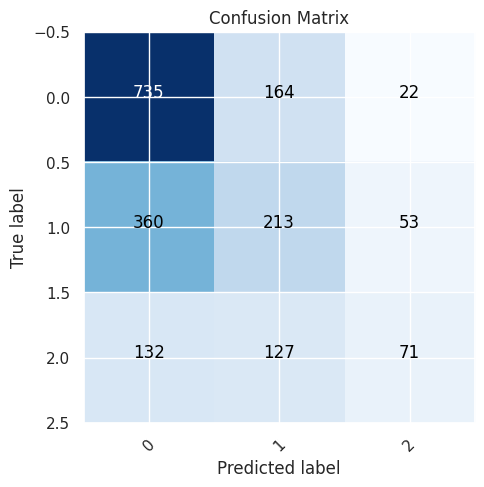

In [59]:
import itertools
classes = [0,1,2]
cm = confusion_matrix(y_test, y_pred_opt)


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Better results could be optain by doing a longer hyperparameter optimization, using actual feature selection for each model and using nested cross validation to have more robust models.

The model emphesis a lot the majority class, weight could be added to prevent that.